In [1]:
# If gspx is not installed, we add it to the path
import os, sys
gdir = os.path.dirname(os.getcwd())  # parent folder
sys.path.insert(0, gdir)

In [2]:
import numpy as np
from gspx.signals import QuaternionSignal
from gspx.utils.display import plot_graph, plot_nodes_plotly
from gspx.datasets import SocialGraphData
from gspx.qgsp import create_quaternion_weights, QGFT, QMatrix
from gspx.adaptive import QLMS

In [3]:
from gspx.datasets import WeatherGraphData

data = WeatherGraphData(n_neighbors=8)
Ar, coords = data.graph

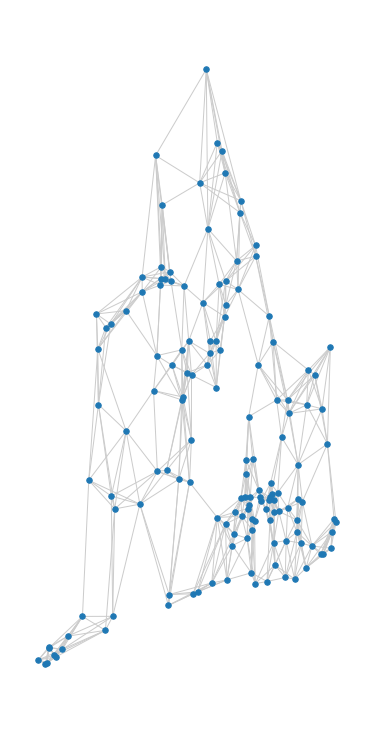

In [4]:
plot_graph(
    Ar, coords, figsize=(5, 10), node_size=30
)

In [5]:
Aq = create_quaternion_weights(
    Ar, data.data, icols=['humidity'],
    jcols=['temp'],
    kcols=['wind_speed'], hermitian=False)

qgft = QGFT()
qgft.fit(Aq)

100%|██████████| 1260/1260 [00:05<00:00, 227.50it/s]


Please wait while the dense quaternion matrix is assembled.
Running eigendecomposition of the shift operator.
Sorting the frequencies based on Total Variation.


In [6]:
data.describe_graph()

n_nodes: 145
n_edges: 630
n_self_loops: 0
density: 0.0603448275862069
is_connected: True
n_connected_components: 1
is_directed: False
is_weighted: True


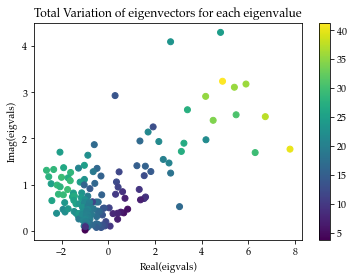

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.scatter(np.real(qgft.eigc), np.imag(qgft.eigc), c=qgft.tv_)
plt.colorbar()
plt.title("Total Variation of eigenvectors for each eigenvalue")
plt.xlabel("Real(eigvals)")
plt.ylabel("Imag(eigvals)")
# plt.savefig('../../phd-thesis/thesis/Figures/uk_qgsp_tv.pdf', dpi=300)
plt.show()